In [1]:
import os
import argparse
from plantcv import plantcv as pcv 
import analyze_area
import json
import cv2
from matplotlib import pyplot as plt
import numpy as np
import csv
import cluster_jordan 
import math
import show_objects

# set to "plot" to see image at every step (takes longer)
pcv.params.debug = None

In [2]:
map_dict = {}
with open("./key_G.csv") as map:
    map = csv.reader(map, delimiter=",")
    for img, plate, exp in map:
        img = img[-12:]
        map_dict[f"{img}"] = (plate, exp)
imagelink = f"./G_plates/IMG_8513.JPG"
area_dict = {}
photo = imagelink[-12:]
area_dict[f'plate'] = map_dict[f'{photo.upper()}']
label = f"exp_{area_dict['plate'][1]}_plate_{area_dict['plate'][0]}_{photo[0:8]}"
print(label)

exp_G_plate_85_IMG_8513


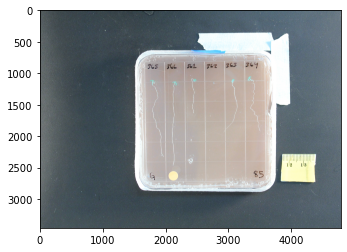

In [3]:
image = cv2.imread(imagelink)
shape = np.shape(image)

if shape[0] > shape[1]:
    image = pcv.rotate(image, 90, crop = None)
image = image[0:,:-400]
plt.imshow(image)

In [4]:
#image = cv2.imread(f"{imagelink}")
thresh = pcv.rgb2gray_hsv(rgb_img=image, channel="h")
thresh = pcv.gaussian_blur(img=thresh, ksize=(101, 101), sigma_x=0, sigma_y=None)
thresh = pcv.threshold.binary(gray_img=thresh, threshold=80, max_value=325, object_type="light")
#thresh = pcv.threshold.otsu(gray_img=thresh, max_value=255, object_type='light')
fill = pcv.fill(bin_img=thresh, size=350000)
dilate = pcv.dilate(gray_img=fill, ksize=120, i=1)
id_objects, obj_hierarchy = pcv.find_objects(img=image, mask=dilate)

In [5]:
cnt = id_objects[0]
x,y,w,h = cv2.boundingRect(cnt)
img = image[(y):(y+h),(x):(x+w)]
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)

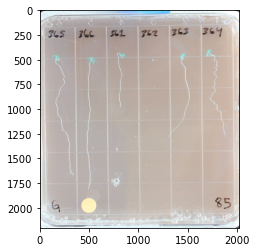

In [6]:
angle = rect[2]
if angle < 4.0 and angle > -4.0:
    center = rect[0]
    width, height = rect[1]
    height = height-20
    M = cv2.getRotationMatrix2D(center,angle,1.0)
    img = cv2.warpAffine(img, M, (int(width-100), int(height)))
else: 
    width = w-100
    height = h-70

img = img[0:, 100:-100]
plt.imshow(img)

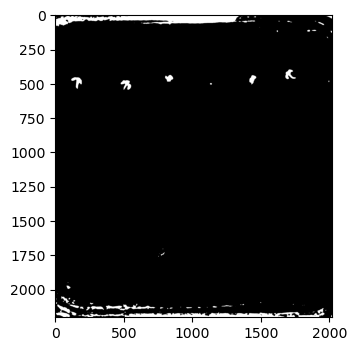

In [7]:
blur = pcv.gaussian_blur(img=img, ksize=(21, 21), sigma_x=0, sigma_y=None)

b = pcv.rgb2gray_lab(rgb_img=blur, channel="b")
avg = np.average(img)
std = np.std(img)
if avg > 220 and std < 25:
    b = pcv.hist_equalization(b)
    t = 251
else: 
    t = 140
# defining a threshold between the leaf and the background
pcv.params.debug = "plot"
b_thresh = pcv.threshold.binary(gray_img=b, threshold= t-6, max_value=255, object_type="light")
pcv.params.debug = None
# filling in small gaps within each leaf
bsa_fill1 = pcv.fill(bin_img=b_thresh, size=300)
#bsa_fill1 = pcv.fill_holes(bin_img=bsa_fill1)
bsa_fill1 = pcv.closing(gray_img=bsa_fill1)
bsa_fill1 = pcv.erode(gray_img = bsa_fill1, ksize = 3, i = 1)
bsa_fill1 = pcv.dilate(gray_img=bsa_fill1, ksize = 3, i = 1)
bsa_fill1 = pcv.fill(bin_img=bsa_fill1, size=300)

In [8]:
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=bsa_fill1)

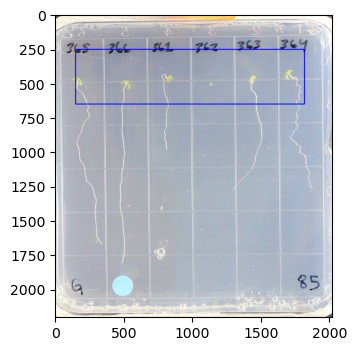

In [9]:
pcv.params.debug = "plot"
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=150, y=250, h=400, w=int(width-450))
pcv.params.debug = None

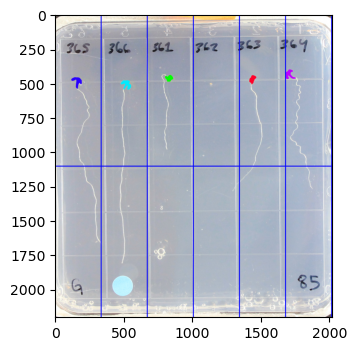

This function has been updated to include object hierarchy so object holes can be included


In [10]:
# gives 4 diff outputs
# list of objs, hierarchies say object or hole w/i object
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, 
                                                              roi_contour=roi_contour, roi_hierarchy=roi_hierarchy,
                                                              object_contour=id_objects, obj_hierarchy=obj_hierarchy, roi_type="partial")

# clustering defined leaves into individual plants using predefined rows/cols
pcv.params.debug = "plot"
clusters_i, contours, hierarchies = cluster_jordan.cluster_contours(img=img, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=hierarchy, nrow=2, ncol=6, show_grid=True)
pcv.params.debug = None
# split the clusters into individual images for analysis
output_path, imgs, masks = cluster_jordan.cluster_contour_splitimg(rgb_img=img,
                                                        grouped_contour_indexes=clusters_i, contours=contours, 
                                                        hierarchy=hierarchies)

In [11]:
sus = False
num_plants = 0
for i in range(0,6):
    pos = 7-(i+1)
    if clusters_i[i][0] != None:
        id_objects, obj_hierarchy = pcv.find_objects(img=imgs[num_plants], mask=masks[num_plants])
        obj, mask1 = pcv.object_composition(img=imgs[num_plants], contours=id_objects, hierarchy=obj_hierarchy)
        m = cv2.moments(obj)
        area = m['m00']
        num_plants += 1
        center, expect_r = cv2.minEnclosingCircle(obj)
        r = math.sqrt(area/math.pi)
        leaf_error = False
        if r <= 0.35*expect_r:
            leaf_error = True
            sus = True
            print(f"warning: there may be an error detecting leaf {pos}")
        with open('./plates_info.csv') as dataab:
            opendata = csv.reader(dataab, delimiter=',') 
            for exp, plate, tube, loc, CS_number, nsource, nconc in opendata:
                if plate == area_dict['plate'][0] and exp == area_dict['plate'][1]:
                    loc = int(loc)
                    if pos == loc:
                        entry = {'position':pos, 'tube':tube, 'area':area, 'suspicious':leaf_error}
                        area_dict[f'plant_{pos}'] = entry
                        break
                    else:
                        entry = {'position':pos, 'tube':None, 'area':area, 'suspicious':leaf_error}
                    area_dict[f'plant_{pos}'] = entry
    else:
        with open('./plates_info.csv') as dataab:
            opendata = csv.reader(dataab, delimiter=',') 
            for exp, plate, tube, loc, CS_number, nsource, nconc in opendata:
                if plate == area_dict['plate'][0] and exp == area_dict['plate'][1]:
                    loc = int(loc)
                    if pos == loc:
                        entry = {'position':pos, 'tube':tube, 'area':0, 'suspicious':None}
                        area_dict[f'plant_{pos}'] = entry
                        break
                    else:
                        entry = {'position':pos, 'tube':None, 'area':0, 'suspicious':None}
                    area_dict[f'plant_{pos}'] = entry
print(area_dict)

{'plate': ('85', 'G'), 'plant_6': {'position': 6, 'tube': '365', 'area': 2745.0, 'suspicious': False}, 'plant_5': {'position': 5, 'tube': '366', 'area': 2884.5, 'suspicious': False}, 'plant_4': {'position': 4, 'tube': '361', 'area': 1857.0, 'suspicious': False}, 'plant_3': {'position': 3, 'tube': None, 'area': 0, 'suspicious': None}, 'plant_2': {'position': 2, 'tube': '363', 'area': 1889.0, 'suspicious': False}, 'plant_1': {'position': 1, 'tube': '364', 'area': 2527.5, 'suspicious': False}}


In [12]:
scale_crop = img

In [13]:
roi_contour_scale, roi_hierarchy_scale = pcv.roi.rectangle(img=scale_crop, x=125, y=height-600, h=500, w=width-500)

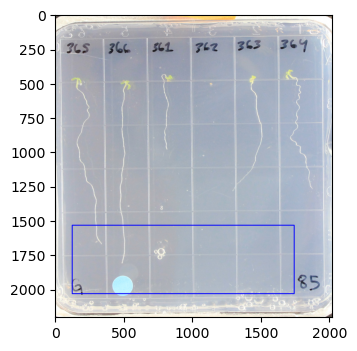

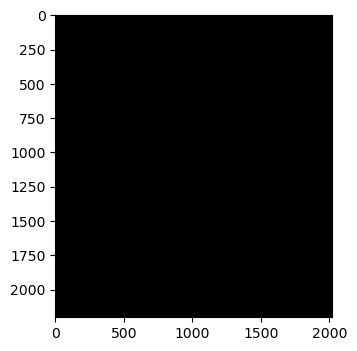

In [14]:
a_scale = pcv.rgb2gray_lab(rgb_img=scale_crop, channel="b")
a_scale = pcv.hist_equalization(a_scale)
a_scale = pcv.gaussian_blur(img=a_scale, ksize=(21, 21), sigma_x=0, sigma_y=None)
a_scale_thresh = pcv.threshold.binary(gray_img=a_scale, threshold=245, max_value=255, object_type="light")
if len(np.unique(a_scale_thresh)) != 1:
    a_scale_thresh = pcv.closing(gray_img=a_scale_thresh)
    if len(np.unique(a_scale_thresh)) != 1:
        a_scale_thresh = pcv.fill(bin_img = a_scale_thresh, size= 4000)
        if len(np.unique(a_scale_thresh)) != 1:
            a_scale_thresh = pcv.fill_holes(bin_img=a_scale_thresh)
            a_scale_thresh = pcv.erode(gray_img=a_scale_thresh, ksize = 9, i = 1)
            a_scale_thresh = pcv.fill(bin_img=a_scale_thresh, size=500)
            a_scale_thresh = pcv.dilate(gray_img=a_scale_thresh, ksize = 9, i = 1)
id_scale, obj_hierarchy = pcv.find_objects(img=scale_crop, mask=a_scale_thresh)
pcv.params.debug = "plot"
roi_scale, scale_hierarchy, scale_mask, scale_area = pcv.roi_objects(img=scale_crop, 
                                                              roi_contour=roi_contour_scale, roi_hierarchy=roi_hierarchy_scale,
                                                                     object_contour=id_scale, obj_hierarchy=obj_hierarchy, roi_type="partial")
pcv.params.debug = None
count = 0
area_dict['scale'] = 0
for object in roi_scale:
    m = cv2.moments(object)
    area = m['m00']
    (x,y), expect_r = cv2.minEnclosingCircle(object)
    r = math.sqrt(area/math.pi)
    if r >= 0.85*expect_r and area > 8000:
        id_scale = object
        hier = scale_hierarchy[0][count]
        area_dict[f'scale'] = area
        print(area)
        break
    count += 1

In [15]:
#area_dict['scale'] = 0

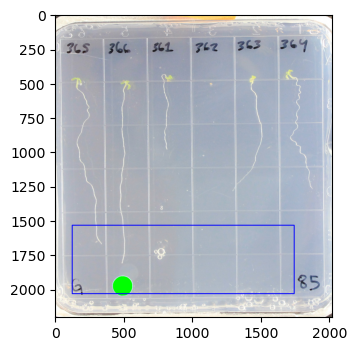

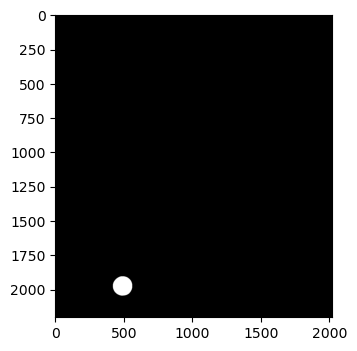

15634.5


In [16]:
if area_dict['scale'] == 0:
    h_scale = pcv.rgb2gray_hsv(rgb_img=scale_crop, channel="v")
    h_scale = pcv.hist_equalization(h_scale)
    h_scale = pcv.gaussian_blur(img=h_scale, ksize=(31, 31), sigma_x=0, sigma_y=None)
    h_scale_thresh = pcv.threshold.binary(gray_img=h_scale, threshold=230, max_value=255, object_type="light")
    h_scale_thresh = pcv.closing(gray_img=h_scale_thresh)
    h_scale_thresh = pcv.fill(bin_img = h_scale_thresh, size= 12000)
    h_scale_thresh = pcv.fill_holes(bin_img=h_scale_thresh)
    h_scale_thresh = pcv.erode(gray_img = h_scale_thresh, ksize = 9, i = 1)
    h_scale_thresh = pcv.fill(bin_img= h_scale_thresh, size=500)
    h_scale_thresh = pcv.dilate(gray_img= h_scale_thresh, ksize = 9, i = 1)
    id_scale_2, obj_hierarchy_2 = pcv.find_objects(img=scale_crop, mask=h_scale_thresh)
    pcv.params.debug = "plot"
    roi_scale, scale_hierarchy, scale_mask, scale_area = pcv.roi_objects(img=scale_crop, 
                                                              roi_contour=roi_contour_scale, roi_hierarchy=roi_hierarchy_scale,
                                                              object_contour=id_scale_2, obj_hierarchy=obj_hierarchy_2, roi_type="partial")
    pcv.params.debug = None
    count2 = 0
    for object in roi_scale: 
        m = cv2.moments(object)
        area = m['m00']
        (x,y), expect_r = cv2.minEnclosingCircle(object)
        r = math.sqrt(area/math.pi)
        if r >= 0.90*expect_r and area > 8000: 
            id_scale = object
            hier = scale_hierarchy[0][count2]
            area_dict[f'scale'] = area
            print(area)
            break
        count2 += 1
   

In [17]:
#area_dict["plant_2"]["suspicious"] = True
#sus = False

In [18]:
if sus != True and area_dict["scale"] != 0:
    areas = {}
    areas[f'{photo}'] = area_dict
    print(areas)

    dict = {}
    if not os.path.isfile('results_G3.json'):
        with open('results_G3.json', 'w') as file:
            json.dump(dict, file)

    with open('results_G3.json') as json_file:
        data = json.load(json_file)
        data.update(areas)

    with open('results_G3.json', 'w') as outfile:
        json.dump(data, outfile)
    
    pcv.params.debug = "print"
    pcv.params.debug_outdir = "./G_plates/out"
    if area_dict['scale'] != 0:
        objs = roi_objects + [id_scale]
        scale_hier = np.array([[hier]])
        hs = np.append(hierarchy, scale_hier, axis=1)
        show_objects.show_objects(img, objs, hs, label)
    else:
        objs = roi_objects + roi_scale
        hs = np.append(hierarchy, scale_hierarchy, axis=1)
        label = label+"FAIL"
        show_objects.show_objects(img, objs, hs, label, red = 255)

{'IMG_8513.JPG': {'plate': ('85', 'G'), 'plant_6': {'position': 6, 'tube': '365', 'area': 2745.0, 'suspicious': False}, 'plant_5': {'position': 5, 'tube': '366', 'area': 2884.5, 'suspicious': False}, 'plant_4': {'position': 4, 'tube': '361', 'area': 1857.0, 'suspicious': False}, 'plant_3': {'position': 3, 'tube': None, 'area': 0, 'suspicious': None}, 'plant_2': {'position': 2, 'tube': '363', 'area': 1889.0, 'suspicious': False}, 'plant_1': {'position': 1, 'tube': '364', 'area': 2527.5, 'suspicious': False}, 'scale': 15634.5}}


In [19]:
pcv.params.debug = "plot"